# Feature Engineering

Pour commencer ce projet, on a accès à une base de données contenant une certaine quantité de clients, chacun identifié par un ID unique? Cette base de données est répartie en multiples fichiers contenant diverses informations sur ces clients. La première étape va donc être de traiter ces données afin de pouvoir les utiliser au mieux, ainsi que de regrouper les tables afin d'obtenir une ligne unique par client dans notre dataset.

Pour accélérer le travail, comme conseillé sur l'énoncé du projet j'ai repris un feature engineering prééxistant via la compétition Kaggle originale que j'ai légèrement adapté et modifié pour une meilleure compréhension et utilisation. Le script original peut être trouvé [ici](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script). L'intérêt de ce feature engineering est d'agréger de nombreuses features en gardant les moyennes/mean/max à travers divers groupby afin d'extraire un maximum d'information pour notre modèle. Il vient également créer quelques nouvelles features à l'aide de pré-existantes. Enfin, il traite toutes les tables une par une, puis les merge ensemble afin d'obtenir un dataset propre avec une ligne unique par ID_CLIENT.

In [1]:
# On importe les différentes librairies
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import warnings
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)

# Fonction pour calculer les temps de traitement
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

On commence par créer une fonction qui applique un one hot encoder sur les features catégorielles d'un dataset.

In [2]:
# Fonction qui applique un one hot encoding avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


On rappelle que nos données sont sous forme de database avec plusieurs tables, on va donc maintenant les traiter une à une.

In [3]:
# Preprocess les données de train et test
def application_train_test(num_rows=None, nan_as_category=False):
    # Importer les données
    df = pd.read_csv('Data/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('Data/application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

    # Joindre les deux tables afin de tout traiter d'un coup
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Retirer les lignes avec Code_gender = XNA
    df = df[df['CODE_GENDER'] != 'XNA']

    # Encoder les variables catégoriques binaires
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Encoder les variables catégoriques avec One Hot Encoder
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Valeurs positives (=365243 par défaut) pour DAYS_EMPLOYED → NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Nouvelles features (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [4]:
# Preprocess les données de bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    # Importer les données
    bureau = pd.read_csv('Data/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('Data/bureau_balance.csv', nrows=num_rows)
    # Transformer les données catégoriques avec One Hot Encoder pour les deux tables
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Agrégations sur bureau_balance
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    # Merge des deux tables
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Traitement des features numériques
    # Dict avec les valeurs qu'on garde pour chaque agrégation de feature
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Traitement des features catégoriques
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    # Agrégations sur bureau sur toutes les colonnes avec les dicts définis précédemment
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # On sépare les valeurs selon si le prêt est ACTIF ou FERME
    # Garder les crédits actifs
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    # Agrégation et rename pour différencier les features
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    # Merge avec la table finale bureau_agg
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Même chose que précédemment pour différencier les crédits FERMES
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [5]:
# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    # Import les données et OHE sur les features catégoriques
    prev = pd.read_csv('Data/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    # Remplacer les valeurs positives (365243) par des NaN
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Nouvelle feature : valeur demandée / valeur reçue en pourcentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # On remplace les valeurs infinies si AMT_CREDIT est nul
    prev['APP_CREDIT_PERC'].replace(np.inf,0,inplace=True)
    
    # Agrégations pour les features numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Prendre la moyenne pour les features catégoriques
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # Agrégation pour chaque demande
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # On vient encore une fois séparer les données entre les demandes approuvées et les demandes refusées
    # Anciennes demandes : Agrégation features numériques pour les demandes approuvées
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Anciennes demandes : Agrégation features numériques pour les demandes refusées
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [6]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('Data/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    # Agrégations des features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Quantité de comptes pos cash
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('Data/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)
    # Nouvelles features : Pourcentage payé et différence pour chaque versement
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    # Remplacer les valeurs infinies si AMT_INSTALMENT est nul
    ins['PAYMENT_PERC'].replace(np.inf,0,inplace=True)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Nouvelles features : Paiement en avance / en retard (Days before and days past), en gardant les valeurs positives
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # Agrégations des features
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Total des versements
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('Data/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Compte le nombre de paiements par ID
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

Maintenant qu'on a créer des fonctions quit traitent les différentes tables une à une, on va définir une fonction qui run toutes les fonctions et merge les datasets retournés en un seul sur le SK_ID_CURR.

In [9]:
# On crée ensuite une fonction main() qui lance toutes les fonctions définies précédemment
def feature_engin(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

Avec toutes ces fonctions on va pouvoir créer un dataset entier, comportant une ligne unique pour chaque demande de prêt avec toutes ses caractéristiques. On va tout de même effectuer une séparation, car on a rassemblé les données du set d'entraînement avec celles du set de test pour la compétition Kaggle.

In [10]:
with timer("Full model run"):
    df = feature_engin()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 14s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 13s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s
Full model run - done in 67s


Après toutes ces agrégations, on a tout de même de nombreuses colonnes dans notre dataset qui sont remplies en grande partie de valeurs manquantes. Retirons donc une partie de ces features.

On va de plus séparer le set d'entraînement afin d'obtenir un set de validation qui servira à contrôler les résultats de la cross validation, le set de test servant uniquement pour obtenir une note via Kaggle. Le travail suivant se fera ensuite à l'aide d'une sample du dataset, afin de réduire les temps de traitement de notre analyse et des cross validation.

In [11]:
import re

# Supprime les features avec trop de valeurs manquantes
def empty_features(data) :
    features = data.loc[:,data.isna().mean()>0.75].columns
    data.drop(features, inplace=True, axis=1) #35 colonnes
    return data

# Sépare le dataset en 2 sets et prend un échantillon
def sample_train_test(data) :
    # Récupérer les sets train et test originaux
    df_test = data[data['TARGET'].isna()].reset_index(drop=True)
    df_train = data[~data['TARGET'].isna()].reset_index(drop=True) 
    
    # Echantillonage
    df_sample = df_train.groupby('TARGET').sample(frac=0.05, random_state=10).reset_index(drop=True)
    
    return df_test, df_train, df_sample

# Renommer certaines colonnes avec des caractères non reconnus
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Appliquer les dernières fonctions
df = empty_features(df)
df_test, df_train, df_sample = sample_train_test(df)

# On sépare le set de train pour créer un set de validation
features_train = [x for x in df_train.columns if x not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
x_train, x_valid, y_train, y_valid = train_test_split(
    df_sample[features_train], 
    df_sample['TARGET'], test_size=0.25, random_state=10, stratify=df_sample['TARGET'])

Maintenant qu'on a un dataset utilisable, on va pouvoir essayer divers modèles afin de comparer les résultats obtenus. On prendra ensuite le modèle le plus performant et on viendra utiliser des algorithmes de cross validation afin d'optimiser ses hyperparamètres.

Cependant, pour comparer ces modèles, ainsi que pour optimiser les paramètres, il va nous falloir utiliser un scorer. Pour cela on va utiliser des scores habituels, tels que l'accuracy ou le F1 score, ou bien l'AUC car c'est le score utilisé dans la compétition Kaggle. On va aussi créer notre propre scorer, qu'on appelera score métier, qui viendra calculer les pertes engendrées par les différentes erreurs de prédiction.

Pour le calcul de ce score, on considère qu'un Faux Négatif (C’est-à-dire un mauvais client prédit comme un bon client) coûte 10 fois plus cher qu'un Faux Positif (Bon client prédit comme mauvais client).

In [12]:
correlations = df.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.dropna().tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 BURO_MONTHS_BALANCE_MIN_MIN               0.073225
CC_AMT_INST_MIN_REGULARITY_MEAN           0.073724
DAYS_EMPLOYED                             0.074957
BURO_DAYS_CREDIT_MIN                      0.075248
BURO_CREDIT_ACTIVE_Active_MEAN            0.077356
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.077681
DAYS_BIRTH                                0.078242
CC_CNT_DRAWINGS_CURRENT_MEAN              0.082520
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN          0.086062
CC_AMT_RECIVABLE_MEAN                     0.086478
CC_AMT_TOTAL_RECEIVABLE_MEAN              0.086490
CC_AMT_BALANCE_MEAN                       0.087177
BURO_DAYS_CREDIT_MEAN                     0.089731
CC_CNT_DRAWINGS_CURRENT_MAX               0.101389
TARGET                                    1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                              -0.178926
EXT_SOURCE_2                              -0.160471
EXT_SOURCE_1                              -

In [13]:
from sklearn.metrics import make_scorer

def score_metier(y_true,y_pred,seuil=0.5) :
    y_true.reset_index(inplace=True,drop=True)
    error = 0
    for i in range (len(y_true)) :
        # Si la probabilité est suffisante le prêt est refusé
        if y_pred[i] > seuil :
            #Prêt refusé alors que le client aurait remboursé = manque à gagner
            if y_true[i] == 0:
                error += 1
        else :
            #Prêt accepté alors que le client ne peut pas rembourser = perte d'argent
            if y_true[i] == 1:
                error += 10
    return error

metier_scorer = make_scorer(score_metier, greater_is_better=False, needs_proba=True)

Dans un objectif de comparaison, commençons en présentant un Classifier très simpliste. Le DummyClassifier peut utiliser plusieurs stratégies : toujours garder la même prédiction, stratifier en fonction des probabilités ou uniformiser les classes. Ces solutions sont dans tous les cas très basiques et ne vont pas nous offrir de très bons résultats, surtout au vu du déséquilibre au sein du dataset.

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(strategy="stratified", random_state = 10)
dummy.fit(x_train,y_train)
probas = dummy.predict_proba(x_valid)
print(classification_report(y_valid, probas[:,1], zero_division=0))
print("---------------------------------------------")
print("AUC Score : ",roc_auc_score(y_valid,probas[:,1]))
print("---------------------------------------------")
print("Score métier : ", score_metier(y_valid, probas[:,1]))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      3534
         1.0       0.08      0.08      0.08       310

    accuracy                           0.85      3844
   macro avg       0.50      0.50      0.50      3844
weighted avg       0.85      0.85      0.85      3844

---------------------------------------------
AUC Score :  0.49900962082625916
---------------------------------------------
Score métier :  3142


On pourrait maintenant travailler avec un classifier plus poussé, tel que LogisticRegression qui est un modèle linéaire. Cependant, il reste certaines valeurs manquantes dans notre dataset, et LogisticRegression ne peut fonctionner avec cela, on va donc commencer par imputer les valeurs manquantes dans le dataset.
L'algorithme de LogisticRegression nous permet également de pallier au déséquilibre des classes grâce au paramètre *class_weight*.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')

x_train_imp = pd.DataFrame(imp.fit_transform(x_train), columns=x_train.columns)
x_valid_imp = pd.DataFrame(imp.transform(x_valid), columns=x_train.columns)

reg = LogisticRegression(class_weight='balanced', max_iter=300)
reg.fit(x_train_imp,y_train)
predict = reg.predict(x_valid_imp)
probas = reg.predict_proba(x_valid_imp)
print(classification_report(y_valid, predict, zero_division=0))
print("---------------------------------------------")
print("AUC Score : ",roc_auc_score(y_valid,probas[:,1]))
print("---------------------------------------------")
print("Score métier : ", score_metier(y_valid, probas[:,1]))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      3534
         1.0       0.16      0.09      0.12       310

    accuracy                           0.89      3844
   macro avg       0.54      0.52      0.53      3844
weighted avg       0.86      0.89      0.87      3844

---------------------------------------------
AUC Score :  0.566558044434708
---------------------------------------------
Score métier :  2967


On pourrait également tenter une autre approche pour résoudre le problème de déséquilibre de classes, en utilisant la librairie SMOTE. Smote est une fonction qui permet d'oversampler les classes sous-représentées, en créant de nouveaux individus proches des individus existants, et ainsi on fait travailler notre modèle directement sur ces données resamplés plutôt que d'intervenir au niveau du poids des classes dans le scoring.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=10, k_neighbors=3)

x_train_bal, y_train_bal = smote.fit_resample(x_train_imp, y_train)


reg = LogisticRegression(max_iter=300)
reg.fit(x_train_bal,y_train_bal)
predict = reg.predict(x_valid_imp)
probas = reg.predict_proba(x_valid_imp)
print(classification_report(y_valid, predict, zero_division=0))
print("---------------------------------------------")
print("AUC Score : ",roc_auc_score(y_valid,probas[:,1]))
print("---------------------------------------------")
print("Score métier : ", score_metier(y_valid, probas[:,1]))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      3534
         1.0       0.15      0.08      0.11       310

    accuracy                           0.89      3844
   macro avg       0.53      0.52      0.52      3844
weighted avg       0.86      0.89      0.87      3844

---------------------------------------------
AUC Score :  0.5677492378187925
---------------------------------------------
Score métier :  2993


On voit qu'en appliquant cette méthode, on trouve un meilleur score AUC, mais le score métier n'est lui pas vraiment meilleur. On rappel cependant que l'on applique notre modèle avec les paramètres de bases et qu'on pourrait sûrement améliorer les performances de notre modèle en les modifiant.

Avant de faire cela, comparons maintenant avec un 3e modèle de classification, LightGBM. LightGBM traite directement les données même avec des valeurs manquantes et des déséquilibres, on applique donc tout d'abord le LGBM sur x_train simple.

In [17]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(verbosity=0)

lgbm.fit(x_train,y_train)
predict = lgbm.predict(x_valid)
probas = lgbm.predict_proba(x_valid)
print(classification_report(y_valid, predict, zero_division=0))
print("---------------------------------------------")
print("AUC Score : ",roc_auc_score(y_valid,probas[:,1]))
print("---------------------------------------------")
print("Score métier : ", score_metier(y_valid, probas[:,1]))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052212 seconds.
You can set `force_col_wise=true` to remove the overhead.
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      3534
         1.0       0.48      0.04      0.08       310

    accuracy                           0.92      3844
   macro avg       0.70      0.52      0.52      3844
weighted avg       0.89      0.92      0.89      3844

---------------------------------------------
AUC Score :  0.7572795151249613
---------------------------------------------
Score métier :  2984


Faisons maintenant un essai en utilisant le paramètre *class_weight* de LightGBM.

In [18]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(verbosity=0, class_weight='balanced')

lgbm.fit(x_train,y_train)
predict = lgbm.predict(x_valid)
probas = lgbm.predict_proba(x_valid)
print(classification_report(y_valid, predict, zero_division=0))
print("---------------------------------------------")
print("AUC Score : ",roc_auc_score(y_valid,probas[:,1]))
print("---------------------------------------------")
print("Score métier : ", score_metier(y_valid, probas[:,1]))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051788 seconds.
You can set `force_col_wise=true` to remove the overhead.
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      3534
         1.0       0.27      0.35      0.30       310

    accuracy                           0.87      3844
   macro avg       0.61      0.63      0.62      3844
weighted avg       0.89      0.87      0.88      3844

---------------------------------------------
AUC Score :  0.7498530405097031
---------------------------------------------
Score métier :  2317


Enfin, essayons en entraînant le modèle grâce au set d'entraînement resamplé.

In [19]:
import lightgbm as lgb

smote = SMOTE(random_state=10, k_neighbors=4)

x_train_bal, y_train_bal = smote.fit_resample(x_train_imp, y_train)

lgbm = lgb.LGBMClassifier(verbosity=0)

lgbm.fit(x_train_bal,y_train_bal)
predict = lgbm.predict(x_valid)
probas = lgbm.predict_proba(x_valid)
print(classification_report(y_valid, predict, zero_division=0))
print("---------------------------------------------")
print("AUC Score : ",roc_auc_score(y_valid,probas[:,1]))
print("---------------------------------------------")
print("Score métier : ", score_metier(y_valid, probas[:,1]))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062091 seconds.
You can set `force_col_wise=true` to remove the overhead.
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      3534
         1.0       0.47      0.05      0.09       310

    accuracy                           0.92      3844
   macro avg       0.70      0.52      0.53      3844
weighted avg       0.89      0.92      0.89      3844

---------------------------------------------
AUC Score :  0.7390930500027384
---------------------------------------------
Score métier :  2958


On voit avec ces 3 résultats que les deux meilleurs méthodes sont en gardant le dataset de base, ou en utilisant smote sur le set de train.

Il apparaît en tous cas largement que LightGBM est le meilleur modèle pour notre problème, c'est donc ce modèle qu'on va maintenant essayé d'optimiser en faisant varier les paramètres.

Pour utiliser la cross validation avec notre resampling, on va devoir créer un Pipeline via la librairie **ImbLearn**. Ce Pipeline va nous permettre d'appliquer le resampling sur x_train au sein de la cross validation, en appliquant smote uniquement à l'échantillon de train et pas celui de validation.

On applique tout d'abord une première fois notre modèle sans modifier aucun paramètre afin d'observer les résultats, et on peut comparer les résultats obtenus sans SMOTE et avec.

In [20]:
from sklearn.model_selection import GridSearchCV
import mlflow
import mlflow.sklearn

model = lgb.LGBMClassifier()

with mlflow.start_run() : 
    opt = GridSearchCV(
         model,
        param_grid={},
        cv = 5,
        scoring=metier_scorer
     )

    with timer('Random Search') :
        opt.fit(x_train, y_train)
        
    mlflow.log_param("Hyperparams", opt.best_params_)
    mlflow.log_metric("Score métier", opt.best_score_)
    print(opt.best_score_)
    print(opt.best_params_)
    
print("AUC",roc_auc_score(y_valid, opt.best_estimator_.predict_proba(x_valid)[:,1]) )

Random Search - done in 7s
-1806.2
{}
AUC 0.7572795151249613


In [21]:
from imblearn.pipeline import Pipeline

model_sm = Pipeline([
        ('sampling', SMOTE(random_state=10)),
        ('classification', lgb.LGBMClassifier())
    ])


opt = GridSearchCV(
     model_sm,
    param_grid={},
    cv = 5,
    scoring=metier_scorer
 )

with timer('Random Search') :
    opt.fit(x_train_imp, y_train)


print(opt.best_score_)
print(opt.best_params_)
print("AUC",roc_auc_score(y_valid, opt.best_estimator_.predict_proba(x_valid_imp)[:,1]) )

Random Search - done in 14s
-1803.8
{}
AUC 0.7418250360552787


On peut voir que les résultats sont plutôt similaires, essayons maintenant d'optimiser les paramètres.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'sampling__k_neighbors' : [3,4,5,6],
    'classification__num_leaves': list(range(5,75,3)),
    'classification__learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.1),base = 10, num = 100)),
    'classification__min_child_samples': list(range(10,50,2)),
    'classification__reg_alpha': list(np.linspace(0, 1)),
    'classification__reg_lambda': list(np.linspace(0, 1)),
    'classification__class_weight' : ['balanced', None]
                          }

with mlflow.start_run() :
    opt = RandomizedSearchCV(
         model_sm,
        param_grid,
         n_iter=500,
        cv = 5,
         random_state=10,
        scoring=metier_scorer
     )

    with timer('Random Search') :
        # On utilise _imp car Smote nécessite 
        opt.fit(x_train_imp, y_train)
        
    mlflow.log_param("Hyperparams", opt.best_params_)
    mlflow.log_metric("Score Metier", opt.best_score_)
    mlflow.log_metric('AUC', roc_auc_score(y_valid, opt.best_estimator_.predict_proba(x_valid_imp)[:,1]))
    print("Score métier", opt.best_score_)
    print("AUC",roc_auc_score(y_valid, opt.best_estimator_.predict_proba(x_valid_imp)[:,1]) )
    print(opt.best_params_)

Random Search - done in 6533s
Score métier -1797.0
AUC 0.6144640998959416
{'sampling__k_neighbors': 5, 'classification__reg_lambda': 0.061224489795918366, 'classification__reg_alpha': 0.36734693877551017, 'classification__num_leaves': 5, 'classification__min_child_samples': 40, 'classification__learning_rate': 0.004999999999999999, 'classification__class_weight': 'balanced'}


In [23]:
param_grid = {
    'num_leaves': list(range(5,75,3)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.1),base = 10, num = 100)),
    'min_child_samples': list(range(10,50,2)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'class_weight' : ['balanced', None]
                          }

with mlflow.start_run() :
    opt = RandomizedSearchCV(
         model,
        param_grid,
         n_iter=500,
        cv = 5,
         random_state=10,
        scoring=metier_scorer
     )

    with timer('Random Search') :
        # On utilise _imp car Smote nécessite 
        opt.fit(x_train, y_train)
        
    mlflow.log_param("Hyperparams", opt.best_params_)
    mlflow.log_metric("Score Metier", opt.best_score_)
    mlflow.log_metric('AUC', roc_auc_score(y_valid, opt.best_estimator_.predict_proba(x_valid)[:,1]))
    print("Score métier", opt.best_score_)
    print("AUC",roc_auc_score(y_valid, opt.best_estimator_.predict_proba(x_valid)[:,1]) )
    print(opt.best_params_)

Random Search - done in 4283s
Score métier -1219.6
AUC 0.7661472880953685
{'reg_lambda': 0.18367346938775508, 'reg_alpha': 0.836734693877551, 'num_leaves': 5, 'min_child_samples': 34, 'learning_rate': 0.08339685962318928, 'class_weight': 'balanced'}


On peut voir ici que les résultats sont bien meilleurs en terme d'optimisation du score métier lorsqu'on retire SMOTE. Même en répétant cette recherche aléatoire de paramètres afin de s'assurer de trouver les meilleurs paramètres, utiliser le classifier par lui même permet d'obtenir de bien meilleurs résultats. Cela peut s'expliquer par le fait que LightGBM prend déjà en compte ce déséquilibre avec le paramètre ***class_weight***. On va donc continuer pour la suite en utilisant le modèle LGBMClassifier tout seul.

In [24]:
# On conserve le modèle et les paramètres optimaux au cas où on en aurait besoin.
best_est = opt.best_estimator_
best_params = opt.best_params_

On a pu trouvé un très bon score avec la RandomizedSearch, on peut cependant essayer d'améliorer encore un peu avec un GridSearch en ajoutant quelques valeurs sur nos variables entières.

In [25]:
with mlflow.start_run() :
    opt = GridSearchCV(
         model,
        param_grid={'min_child_samples': [30,31,32,33,34],
                   'reg_alpha': [0.836734693877551],
                    'reg_lambda': [0.18367346938775508],
                   'learning_rate': [0.08339685962318928],
                   'num_leaves': [4,5,6],
                   'class_weight': ['balanced']},
        cv = 5,
        scoring=metier_scorer
     )

    with timer('Random Search') :
        opt.fit(x_train, y_train)

    print(opt.best_score_)
    print(opt.best_params_)

    mlflow.log_param("Hyperparams", opt.best_params_)
    mlflow.log_metric("Score métier", opt.best_score_)

Random Search - done in 40s
-1212.2
{'class_weight': 'balanced', 'learning_rate': 0.08339685962318928, 'min_child_samples': 32, 'num_leaves': 5, 'reg_alpha': 0.836734693877551, 'reg_lambda': 0.18367346938775508}


On pourrait également essayer de faire varier le seuil de notre score métier, car le seuil de base de 0.5 n'est peut être pas optimal pour nos prédictions.

In [26]:
seuils = [0.25,0.4,0.5,0.75]
for lim in seuils : 
    metier_scorer = make_scorer(score_metier, greater_is_better=False, needs_proba=True, **{'seuil':lim})
    with mlflow.start_run() :
        opt = GridSearchCV(
             model,
            param_grid={'min_child_samples': [32],
                   'reg_alpha': [0.836734693877551],
                    'reg_lambda': [0.18367346938775508],
                   'learning_rate': [0.08339685962318928],
                   'num_leaves': [5],
                   'class_weight': ['balanced']},
            cv = 5,
            scoring=metier_scorer
         )

        with timer('Random Search') :
            opt.fit(x_train, y_train)
            
        print(opt.best_score_)
        print(lim)
        
        mlflow.log_param("Hyperparams", opt.best_params_)
        mlflow.log_metric("AUC", opt.best_score_)

metier_scorer = make_scorer(score_metier, greater_is_better=False, needs_proba=True, **{'seuil':0.5})

Random Search - done in 3s
-1634.8
0.25
Random Search - done in 3s
-1294.8
0.4
Random Search - done in 3s
-1212.2
0.5
Random Search - done in 3s
-1638.6
0.75


Il semblerait que 0.5 soit effectivement le seuil optimal pour notre modèle. En même temps, c'est le seuil qui était présent lors de l'optimisation du moèdle, il paraît donc cohérent que ce seuil soit le meilleur, mais il serait compliqué d'intégrer divers seuils lors de la cross-validation en même temps que tous les autres paramètres.

On pourrait maintenant afficher une heatmap des prédictions de notre modèle afin d'observer de plus près les différents erreurs qu'il commet.

Erreur métier 1968


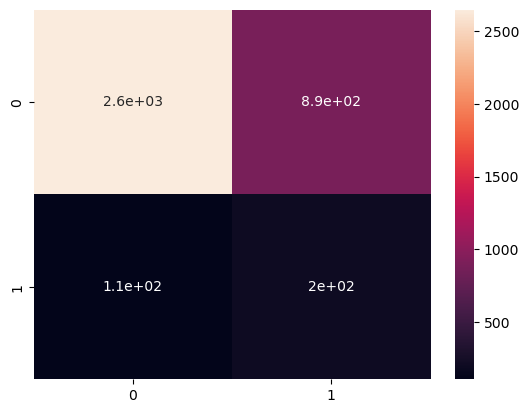

AUC 0.700169779286927
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84      3534
         1.0       0.19      0.65      0.29       310

    accuracy                           0.74      3844
   macro avg       0.57      0.70      0.57      3844
weighted avg       0.90      0.74      0.80      3844



In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

probas = opt.best_estimator_.predict_proba(x_valid)
prediction = opt.best_estimator_.predict(x_valid)
error = score_metier(y_valid, probas[:,1])

print("Erreur métier",error)
sns.heatmap(confusion_matrix(y_valid,prediction),annot=True)
plt.show()

print("AUC", roc_auc_score(y_valid,prediction))

print(classification_report(y_valid,prediction))

On peut finalement essayer ce modèle sur l'ensemble des données qui n'ont pas encore été étudiées afin d'avoir un échantillon plus grand, car on a pour l'instant travailler sur une partie très réduite du dataset. On prend ici l'ensemble des lignes qui ne faisaient pas partie du sample pour valider.

Erreur métier 157576


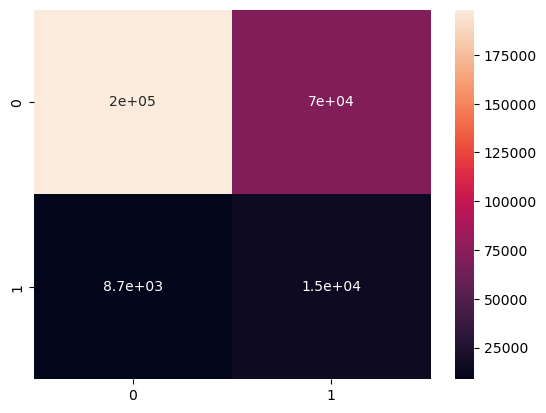

AUC 0.6840854108432242
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83    268548
         1.0       0.17      0.63      0.27     23584

    accuracy                           0.73    292132
   macro avg       0.57      0.68      0.55    292132
weighted avg       0.89      0.73      0.79    292132



In [28]:
testing = df_train[~df_train['SK_ID_CURR'].isin(df_sample['SK_ID_CURR'])]
probas = opt.best_estimator_.predict_proba(testing.drop(['SK_ID_CURR', 'TARGET'], axis=1))
prediction = opt.best_estimator_.predict(testing.drop(['SK_ID_CURR', 'TARGET'], axis=1))
error = score_metier(testing['TARGET'], probas[:,1])

print("Erreur métier",error)
sns.heatmap(confusion_matrix(testing['TARGET'],prediction),annot=True)
plt.show()

print("AUC", roc_auc_score(testing['TARGET'],prediction))

print(classification_report(testing['TARGET'],prediction))

On peut donc voir que la grande majorité des erreurs concernent des clients refusés alors qu'ils sont de bons clients. Cela représente donc un manque à gagner, mais ce sont des erreurs moins graves que d'allouer des prêts qui ne seront pas remboursés.

On pourrait évidemment améliorer notre score et modèle, notre AUC de 0.7 est améliorable comme on peut le voir sur la compétition Kaggle. C'est cependant déjà un score très satisfaisant et ce modèle fonctionnera très bien pour notre projet.

On exporte ce modèle pour pouvoir l'utiliser dans l'API par la suite.

In [54]:
import joblib

# On refit sur l'ensemble des données d'entraînement afin de travailler sur le set de test ensuite.
best_est.fit(df_train.drop(['SK_ID_CURR', 'TARGET'], axis=1), df_train['TARGET'])

# Exporter le modèle
joblib.dump(best_est, 'lgb_opti.pkl')

['lgb_opti.pkl']

In [30]:
# On exporte aussi le set de test modifié pour l'API
df_test.to_csv('df_test.csv')

## Feature Importances

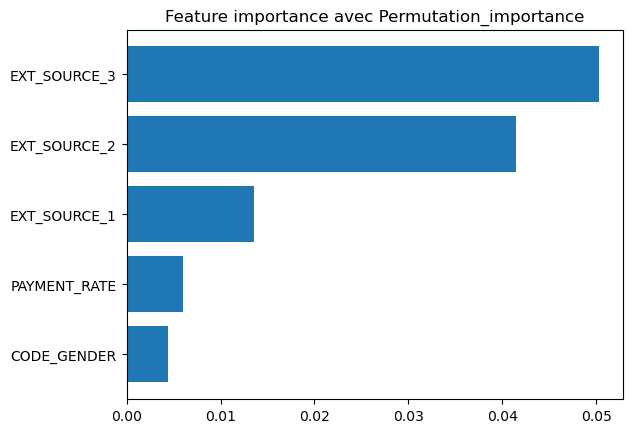

In [31]:
from sklearn.inspection import permutation_importance

# Calculer les permutation_importance
results = permutation_importance(best_est, x_train, y_train, scoring='roc_auc')
importance = results.importances_mean

# Modification des données afin de réduire le nombres de variables affichées
imp = pd.Series(importance, index=x_train.columns)
mask = np.sort([x for x in importance if  abs(x)>0.004])
features = imp.loc[imp.isin(mask)].sort_values()


# Affichage des features importances
plt.barh([x for x in range(len(mask))], mask, tick_label = features.index )
plt.title("Feature importance avec Permutation_importance")
plt.show()

On peut maintenant afficher les features importances du modèle, à l'aide de la librairie SHAP.

100%|===================| 306852/307507 [07:04<00:00]        

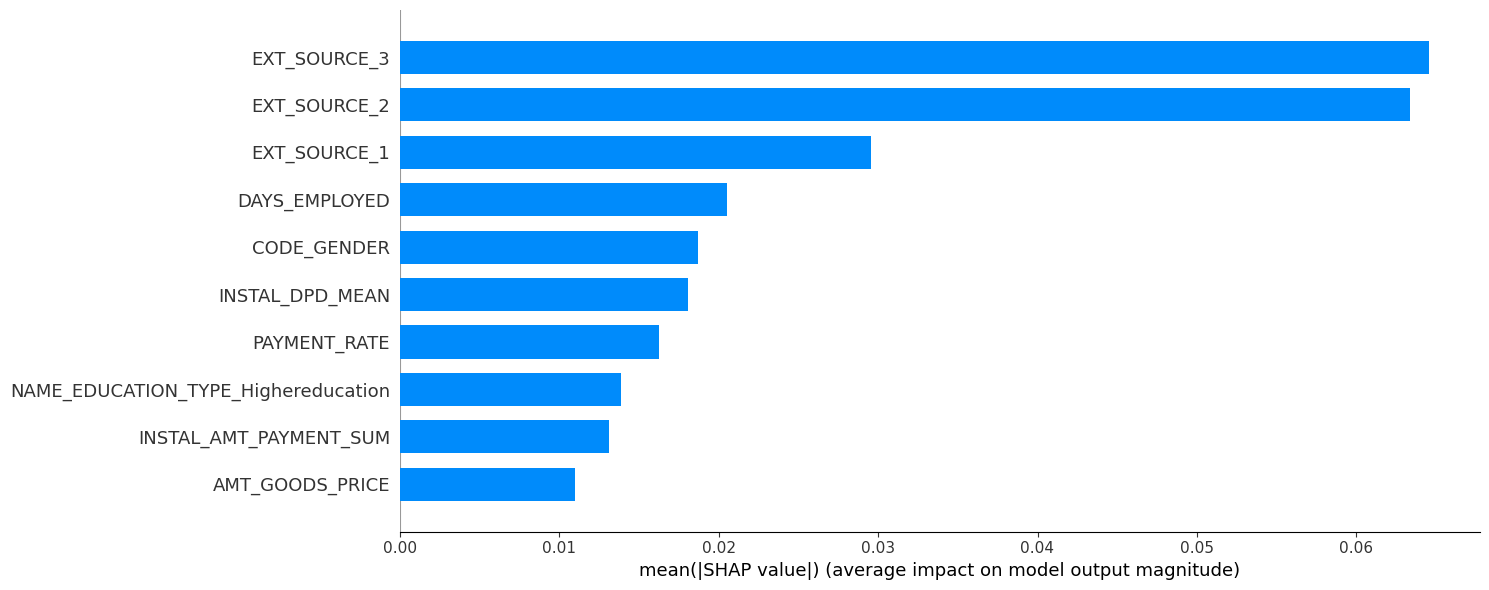

In [55]:
import shap
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
shap.initjs()

explainer = shap.TreeExplainer(best_est, df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1), model_output='probability')
shap_values = explainer.shap_values(df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1))

shap.summary_plot(shap_values, df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1), feature_names=x_train.columns, plot_size = (15,6), plot_type='bar',max_display=10)

In [53]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1).iloc[0,:],
    feature_names=x_train.columns
)